In [3]:
from matplotlib.colors import ListedColormap
from PIL import Image
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tiatoolbox.tools.patchextraction import SlidingWindowPatchExtractor
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from tiatoolbox.wsicore.wsireader import WSIReader
import pandas as pd
import glob

In [4]:
coord_data = pd.read_csv("/lab/deasylab3/Himangi/TCGA_roi_coordinates.csv")

slide  \
0    TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD...   
1    TCGA-A1-A0SP-01Z-00-DX1.20D689C6-EFA5-4694-BE7...   
2    TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FD...   
3    TCGA-A2-A04Q-01Z-00-DX1.DF7ED6B6-7701-486D-900...   
4    TCGA-A2-A04T-01Z-00-DX1.71444266-BD56-4183-960...   
..                                                 ...   
138  TCGA-OL-A66P-01Z-00-DX1.5ADD0D6D-37C6-4BC9-8C2...   
139  TCGA-OL-A6VO-01Z-00-DX1.291D54D6-EBAF-4622-BD4...   
140  TCGA-OL-A97C-01Z-00-DX1.BDEEDEE2-6D07-4046-A8A...   
141  TCGA-S3-AA10-01Z-00-DX1.C0468882-0DD8-4FC5-8C2...   
142  TCGA-S3-AA15-01Z-00-DX1.A2456A4A-E6E8-4429-8F0...   

                                                  mask  \
0    TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD...   
1    TCGA-A1-A0SP-01Z-00-DX1.20D689C6-EFA5-4694-BE7...   
2    TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FD...   
3    TCGA-A2-A04Q-01Z-00-DX1.DF7ED6B6-7701-486D-900...   
4    TCGA-A2-A04T-01Z-00-DX1.71444266-BD56-4183-960...   
..                                                 ...   
138  TCGA-OL-A66P-01Z-00-DX1.5ADD0D6D-37C6-4BC9-8C2...   
139  TCGA-OL-A6VO-01Z-00-DX1.291D54D6-EBAF-4622-BD4...   
140  TCGA-OL-A97C-01Z-00-DX1.BDEEDEE2-6D07-4046-A8A...   
141  TCGA-S3-AA10-01Z-00-DX1.C0468882-0DD8-4FC5-8C2...   
142  TCGA-S3-AA15-01Z-00-DX1.A2456A4A-E6E8-4429-8F0...   

                                                   xml  coord_x1  coord_y1  \
0    TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD...     22877     12530   
1    TCGA-A1-A0SP-01Z-00-DX1.20D689C6-EFA5-4694-BE7...      3401     26862   
2    TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FD...     52125     24261   
3    TCGA-A2-A04Q-01Z-00-DX1.DF7ED6B6-7701-486D-900...     10436      8904   
4    TCGA-A2-A04T-01Z-00-DX1.71444266-BD56-4183-960...     36075     19541   
..                                                 ...       ...       ...   
138  TCGA-OL-A66P-01Z-00-DX1.5ADD0D6D-37C6-4BC9-8C2...      7537      5079   
139  TCGA-OL-A6VO-01Z-00-DX1.291D54D6-EBAF-4622-BD4...     22105     47123   
140  TCGA-OL-A97C-01Z-00-DX1.BDEEDEE2-6D07-4046-A8A...     34032     16250   
141  TCGA-S3-AA10-01Z-00-DX1.C0468882-0DD8-4FC5-8C2...     21523     11996   
142  TCGA-S3-AA15-01Z-00-DX1.A2456A4A-E6E8-4429-8F0...     27745     14465   

     coord_x2  coord_y2  
0       24892     13993  
1        6276     28896  
2       54392     26004  
3       11520      9986  
4       39828     21434  
..        ...       ...  
138     10001      7043  
139     23430     48486  
140     36705     19096  
141     23442     13924  
142     28848     15836  

[143 rows x 7 columns]

In [5]:
data_path = '/lab/deasylab3/Jung/tiger/'
dir_TIFF_images = data_path + "/wsirois/wsi-level-annotations/images/"


imgs_names = os.listdir(dir_TIFF_images)
imgs_names.sort()

imgs_names = [i for i in imgs_names if i.startswith('TCGA')]    


In [20]:
import pandas as pd
import os
from tiatoolbox.wsicore.wsireader import WSIReader
from PIL import Image
import matplotlib.pyplot as plt

# === CONFIG ===
csv_path = "/lab/deasylab3/Himangi/TCGA_roi_coordinates.csv"
slide_dir = dir_TIFF_images
output_dir = "tumor_rois_output"
os.makedirs(output_dir, exist_ok=True)

# Margin in microns for peritumoral region
margin_um = 500  

# Load CSV
df = pd.read_csv(csv_path)

# Process first 10 rows
for idx, row in df.head(10).iterrows():
    slide_name = row['slide']
    slide_path = os.path.join(slide_dir, slide_name)

    try:
        reader = WSIReader.open(slide_path)
    except Exception as e:
        print(f"[ERROR] Could not open slide {slide_name}: {e}")
        continue

    # === Resolution ===
    # Get resolution in microns-per-pixel (x, y)
    mpp = reader.info.mpp
    print(f"[INFO] {slide_name} MPP: {mpp}")
    
    margin_px = int(margin_um / mpp[0])  # Use x-resolution


    margin_px = int(margin_um / mpp[0])  # convert µm to px using x-mpp

    # === Tumor box from CSV ===
    x1, x2 = row['coord_x1'], row['coord_x2']
    y1, y2 = row['coord_y1'], row['coord_y2']
    width = x2 - x1
    height = y2 - y1

    # === Read tumor ROI ===
    tumor_img = reader.read_rect(
        location=(x1, y1),
        size=(width, height),
    )

    # === Read peritumoral ROI ===
    px1 = max(x1 - margin_px, 0)
    py1 = max(y1 - margin_px, 0)
    level0_dims = reader.slide_dimensions(resolution=0, units="level")
    px2 = min(x2 + margin_px, level0_dims[0])
    py2 = min(y2 + margin_px, level0_dims[1])
    p_width = px2 - px1
    p_height = py2 - py1

    peritumoral_img = reader.read_rect(
        location=(px1, py1),
        size=(p_width, p_height),
    )

    # === Save images ===
    base_name = os.path.splitext(slide_name)[0]
    #tumor_path = os.path.join(output_dir, f"{idx:02d}_{base_name}_tumor.png")
    peri_path = os.path.join(output_dir, f"{idx:02d}_{base_name}_peritumoral.png")

    #Image.fromarray(tumor_img).save(tumor_path)
    Image.fromarray(peritumoral_img).save(peri_path)

    #print(f"[SAVED] Tumor ROI: {tumor_path}")
    print(f"[SAVED] Peritumoral ROI: {peri_path}")


|2025-07-14|15:23:25.417| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297.tif MPP: [0.50420345 0.50420345]
[SAVED] Peritumoral ROI: tumor_rois_output/00_TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297_peritumoral.png


|2025-07-14|15:23:31.831| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A1-A0SP-01Z-00-DX1.20D689C6-EFA5-4694-BE76-24475A89ACC0.tif MPP: [0.50419943 0.50419943]
[SAVED] Peritumoral ROI: tumor_rois_output/01_TCGA-A1-A0SP-01Z-00-DX1.20D689C6-EFA5-4694-BE76-24475A89ACC0_peritumoral.png


|2025-07-14|15:23:41.406| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FDD-6494E6EE2B71.tif MPP: [0.50099892 0.50099892]
[SAVED] Peritumoral ROI: tumor_rois_output/02_TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FDD-6494E6EE2B71_peritumoral.png


|2025-07-14|15:23:48.457| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A2-A04Q-01Z-00-DX1.DF7ED6B6-7701-486D-9007-F26B6F0682C4.tif MPP: [0.50100122 0.50100122]
[SAVED] Peritumoral ROI: tumor_rois_output/03_TCGA-A2-A04Q-01Z-00-DX1.DF7ED6B6-7701-486D-9007-F26B6F0682C4_peritumoral.png


|2025-07-14|15:23:53.223| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A2-A04T-01Z-00-DX1.71444266-BD56-4183-9603-C7AC20C9DA1E.tif MPP: [0.50100034 0.50100034]
[SAVED] Peritumoral ROI: tumor_rois_output/04_TCGA-A2-A04T-01Z-00-DX1.71444266-BD56-4183-9603-C7AC20C9DA1E_peritumoral.png


|2025-07-14|15:24:02.676| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A2-A0CM-01Z-00-DX1.AC4901DE-4B6D-4185-BB9F-156033839828.tif MPP: [0.49699565 0.49699565]
[SAVED] Peritumoral ROI: tumor_rois_output/05_TCGA-A2-A0CM-01Z-00-DX1.AC4901DE-4B6D-4185-BB9F-156033839828_peritumoral.png


|2025-07-14|15:24:10.551| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A2-A0D0-01Z-00-DX1.4FF6B8E5-703B-400F-920A-104F56E0F874.tif MPP: [0.49700009 0.49700009]
[SAVED] Peritumoral ROI: tumor_rois_output/06_TCGA-A2-A0D0-01Z-00-DX1.4FF6B8E5-703B-400F-920A-104F56E0F874_peritumoral.png


|2025-07-14|15:24:27.349| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A2-A0D2-01Z-00-DX1.ECD890F5-BA01-4998-B472-7B683BD6D7B1.tif MPP: [0.49600219 0.49600219]
[SAVED] Peritumoral ROI: tumor_rois_output/07_TCGA-A2-A0D2-01Z-00-DX1.ECD890F5-BA01-4998-B472-7B683BD6D7B1_peritumoral.png


|2025-07-14|15:24:34.425| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A2-A0ST-01Z-00-DX1.AE05A5DB-4861-40DE-B0F5-7955FC903A96.tif MPP: [0.49600239 0.49600239]
[SAVED] Peritumoral ROI: tumor_rois_output/08_TCGA-A2-A0ST-01Z-00-DX1.AE05A5DB-4861-40DE-B0F5-7955FC903A96_peritumoral.png


|2025-07-14|15:24:46.744| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


[INFO] TCGA-A2-A0SX-01Z-00-DX1.219A994C-8974-4458-98FA-FB1F14868E04.tif MPP: [0.49600186 0.49600186]
[SAVED] Peritumoral ROI: tumor_rois_output/09_TCGA-A2-A0SX-01Z-00-DX1.219A994C-8974-4458-98FA-FB1F14868E04_peritumoral.png


In [25]:
direct ="/lab/deasylab3/Himangi/TNBC_multimodal/tumor_rois_output" 


In [29]:
direct = sorted(glob.glob(os.path.join(direct, "*.png")))

In [30]:
direct

['/lab/deasylab3/Himangi/TNBC_multimodal/tumor_rois_output/00_TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297_peritumoral.png',
 '/lab/deasylab3/Himangi/TNBC_multimodal/tumor_rois_output/01_TCGA-A1-A0SP-01Z-00-DX1.20D689C6-EFA5-4694-BE76-24475A89ACC0_peritumoral.png',
 '/lab/deasylab3/Himangi/TNBC_multimodal/tumor_rois_output/02_TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FDD-6494E6EE2B71_peritumoral.png',
 '/lab/deasylab3/Himangi/TNBC_multimodal/tumor_rois_output/03_TCGA-A2-A04Q-01Z-00-DX1.DF7ED6B6-7701-486D-9007-F26B6F0682C4_peritumoral.png',
 '/lab/deasylab3/Himangi/TNBC_multimodal/tumor_rois_output/04_TCGA-A2-A04T-01Z-00-DX1.71444266-BD56-4183-9603-C7AC20C9DA1E_peritumoral.png',
 '/lab/deasylab3/Himangi/TNBC_multimodal/tumor_rois_output/05_TCGA-A2-A0CM-01Z-00-DX1.AC4901DE-4B6D-4185-BB9F-156033839828_peritumoral.png',
 '/lab/deasylab3/Himangi/TNBC_multimodal/tumor_rois_output/06_TCGA-A2-A0D0-01Z-00-DX1.4FF6B8E5-703B-400F-920A-104F56E0F874_peritumoral.png',
 '/lab/deasyl

In [31]:
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,)

# Define your segmentor
bcc_segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    num_loader_workers=4,
    batch_size=4,
    auto_generate_mask=False,
)



bcc_roi_ioconfig = IOSegmentorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 0.25}],   # or a value you assume
    output_resolutions=[{"units": "mpp", "resolution": 0.25}],
    patch_input_shape=[512, 512],
    patch_output_shape=[512, 512],
    stride_shape=[512, 512],
    save_resolution={"units": "mpp", "resolution": 0.25}
)

|2025-07-14|17:46:23.642| [WARNING] /cluster/home/srivash/miniforge3/envs/tiatoolbox-gpu/lib/python3.10/site-packages/tiatoolbox/models/architecture/__init__.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r

In [33]:
wsi_output = bcc_segmentor.predict(
    imgs=direct,
    masks=None,
    save_dir="iterative_roi_results/",
    mode="tile",  # <- Use tile mode for ROI images
    ioconfig=bcc_roi_ioconfig,
    device="cpu",
    crash_on_exception=False,
)


|2025-07-15|09:57:38.645| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2025-07-15|09:57:38.703| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2025-07-15|09:57:39.774| [WARNING] Raw data is None.
|2025-07-15|09:57:39.775| [WARNING] Unknown scale (no objective_power or mpp)
|2025-07-15|09:57:41.246| [WARNING] Raw data is None.
|2025-07-15|09:57:41.245| [WARNING] Raw data is None.
|2025-07-15|09:57:41.248| [WARNING] Raw data is None.
|2025-07-15|09:57:41.254| [WARNING] Raw data is None.
Process Batch: 100%|############################| 14/14 [00:35<00:00,  2.55s/it]

|2025-07-15|09:58:15.605| [INFO] Finish: 0
|2025-07-15|09:58:15.605| [INFO] --Input: /lab/deasylab3/Himangi/TNBC_multimodal/tumor_rois_output/00_TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297_peritumoral.png
|2025-07-15|09:58:15.606| [INFO] --Output: /lab/deasylab3/Himangi/TNBC_multimodal/iterative_roi_results/0



|2025-07-15|09:58:16.921| [WARNING] Raw data is None.
|2025-07-15|09:58:16.922| [WARNING] Unknown scale (no objective_power or mpp)
|2025-07-15|09:58:18.613| [WARNING] Raw data is None.
|2025-07-15|09:58:18.613| [WARNING] Raw data is None.
|2025-07-15|09:58:18.613| [WARNING] Raw data is None.
|2025-07-15|09:58:18.617| [WARNING] Raw data is None.

|2025-07-15|09:59:17.028| [ERROR] Crashed on /lab/deasylab3/Himangi/TNBC_multimodal/iterative_roi_results/1
Traceback (most recent call last):
  File "/cluster/home/srivash/miniforge3/envs/tiatoolbox-gpu/lib/python3.10/site-packages/tiatoolbox/models/engine/semantic_segmentor.py", line 1242, in _predict_wsi_handle_exception
    shutil.copy(map_file_path, old_map_file_path)
  File "/cluster/home/srivash/miniforge3/envs/tiatoolbox-gpu/lib/python3.10/shutil.py", line 418, in copy
    copymode(src, dst, follow_symlinks=follow_symlinks)
  File "/cluster/home/srivash/miniforge3/envs/tiatoolbox-gpu/lib/python3.10/shutil.py", line 307, in copymode
  

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import measure
from skimage.draw import polygon_perimeter
import os





In [36]:
len(wsi_output)

10

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

# --- Configuration ---
png_path = "path_to_your_images"  # Folder with original PNGs
prediction_path = "path_to_prediction_npy_files"  # Folder with .npy raw predictions

# --- Get list of images ---
image_files = [f for f in os.listdir(png_path) if f.endswith(".png")]

for image_name in sorted(image_files):
    # Strip .png extension
    image_id = os.path.splitext(image_name)[0]

    # Construct prediction file path
    pred_file = os.path.join(prediction_path, image_id + ".raw.0.npy")
    img_file = os.path.join(png_path, image_name)

    if not os.path.exists(pred_file):
        print(f"[SKIP] No prediction for {image_name}")
        continue

    try:
        # Load prediction
        tile_prediction_raw = np.load(pred_file)
        tile_prediction = np.argmax(tile_prediction_raw, axis=-1)

        # Load original image
        tile = imread(img_file)
        if tile.ndim == 2:
            tile = np.stack([tile] * 3, axis=-1)
        elif tile.shape[2] == 4:
            tile = tile[:, :, :3]

        # Create tumor mask (class 0)
        tumor_mask = (tile_prediction == 0).astype(np.uint8)

        # Overlay tumor in red
        alpha = 0.4
        tumor_overlay = tile.copy()
        tumor_overlay[tumor_mask == 1] = (
            (1 - alpha) * tile[tumor_mask == 1] + alpha * np.array([255, 0, 0])
        ).astype(np.uint8)

        # --- Plot ---
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(tile)
        plt.title(f"{image_name} - Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(tumor_overlay)
        plt.title("Tumor Overlay")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[ERROR] Processing {image_name}: {e}")


Raw prediction shape: (3445, 3997, 5)
Processed prediction shape: (3445, 3997)


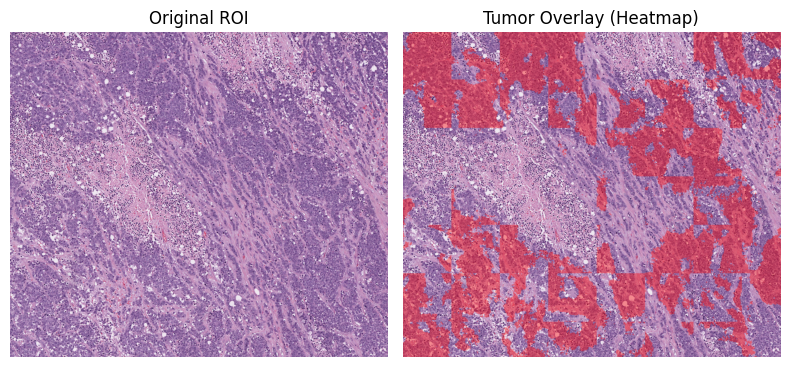

Raw prediction shape: (4016, 4857, 5)
Processed prediction shape: (4016, 4857)


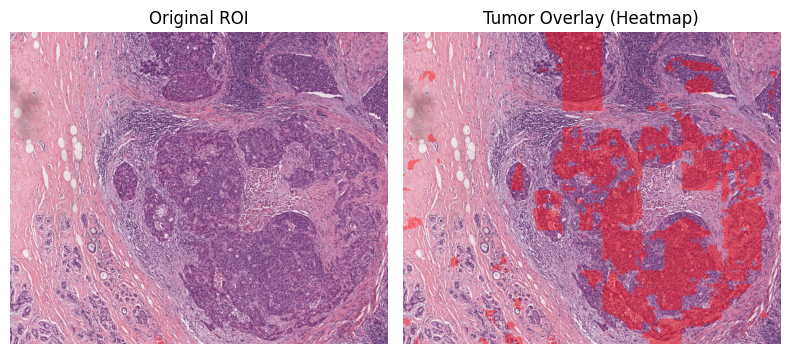

Raw prediction shape: (3739, 4263, 5)
Processed prediction shape: (3739, 4263)


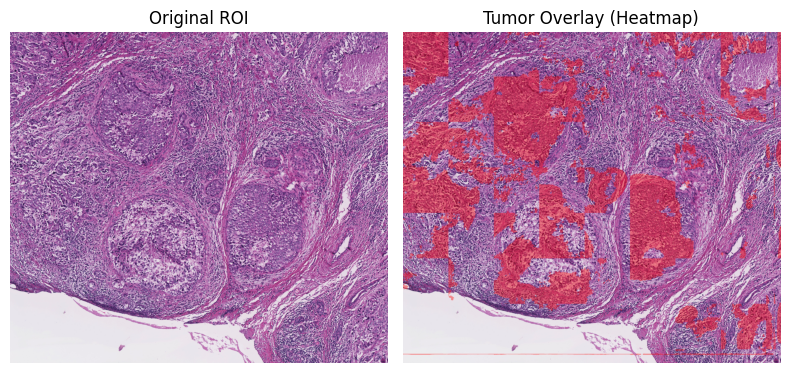

Raw prediction shape: (3078, 3080, 5)
Processed prediction shape: (3078, 3080)


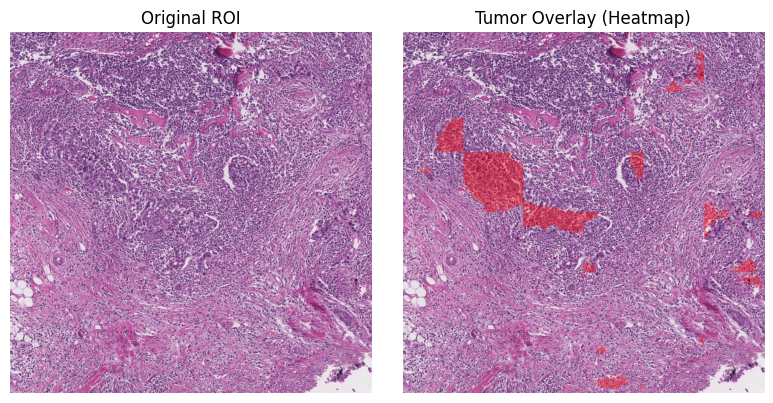

Raw prediction shape: (3889, 5749, 5)
Processed prediction shape: (3889, 5749)


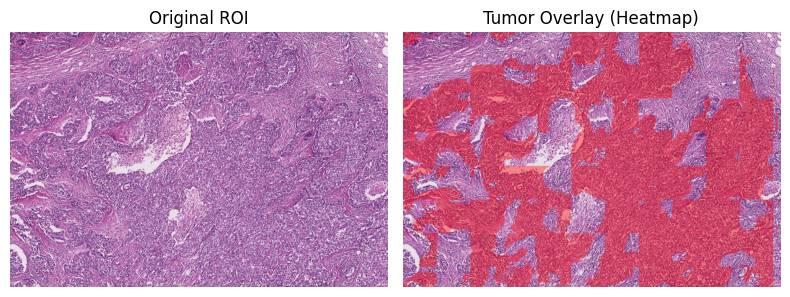

Raw prediction shape: (3958, 4548, 5)
Processed prediction shape: (3958, 4548)


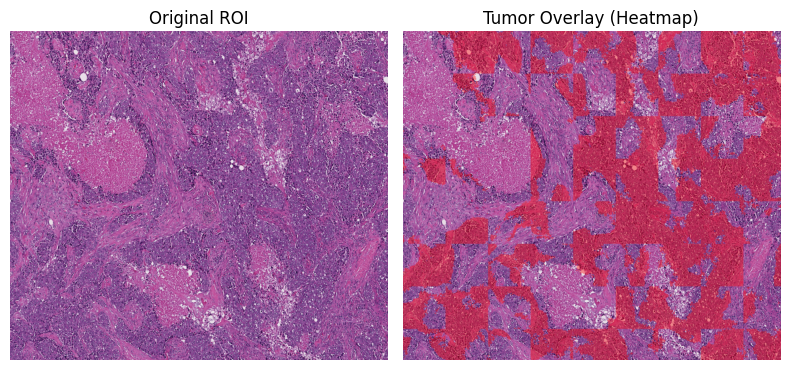

Raw prediction shape: (6120, 6450, 5)
Processed prediction shape: (6120, 6450)


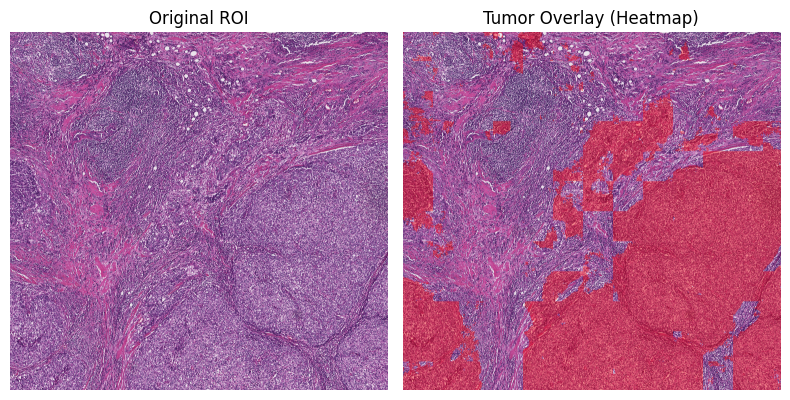

Raw prediction shape: (3474, 4062, 5)
Processed prediction shape: (3474, 4062)


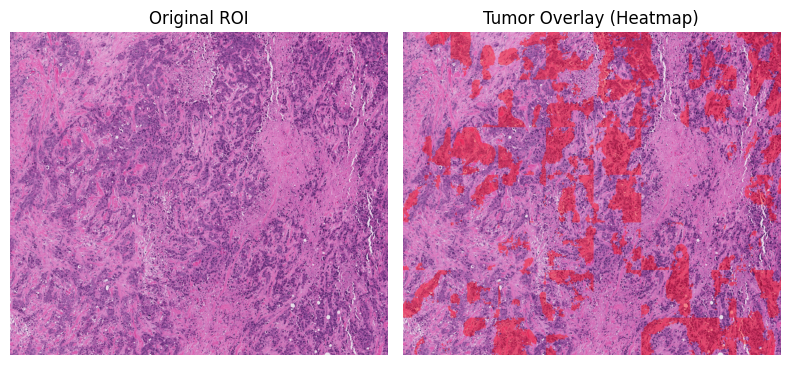

Raw prediction shape: (4809, 5276, 5)
Processed prediction shape: (4809, 5276)


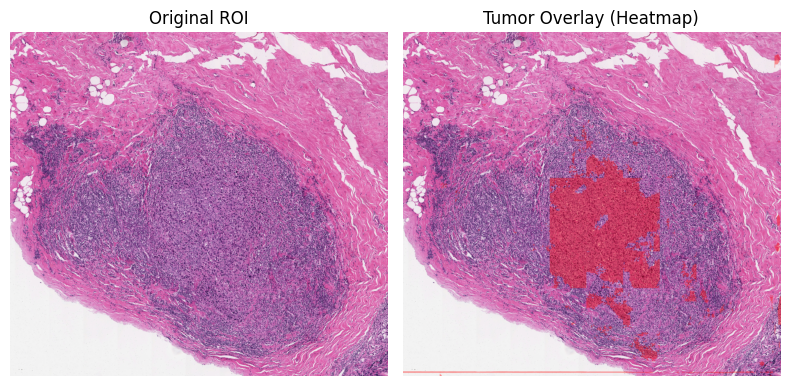

Raw prediction shape: (4549, 3678, 5)
Processed prediction shape: (4549, 3678)


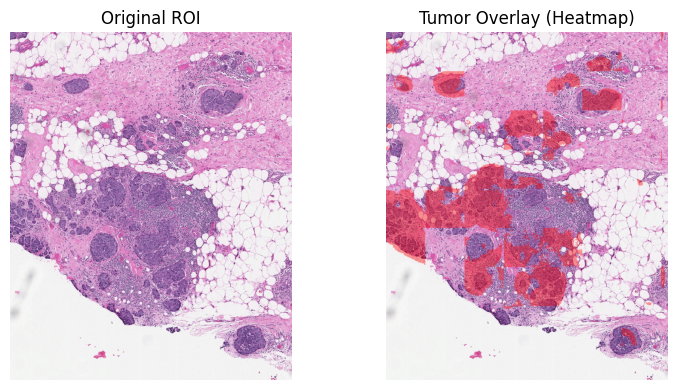

In [39]:
for i in range(len(wsi_output)):
    # Assume wsi_output[0] = (image_name, prediction_path_prefix)
    image_name, prediction_path_prefix = wsi_output[i]
    
    # Load raw prediction (.npy) from disk
    tile_prediction_raw = np.load(prediction_path_prefix + f".raw.{0}.npy")
    print("Raw prediction shape:", tile_prediction_raw.shape)
    
    # Convert softmax to class labels (argmax)
    tile_prediction = np.argmax(tile_prediction_raw, axis=-1)
    print("Processed prediction shape:", tile_prediction.shape)
    
    # Load the original ROI image
    img_path = os.path.join(image_name)  # change as needed
    tile = imread(img_path)
    if tile.ndim == 2:
        tile = np.stack([tile]*3, axis=-1)
    elif tile.shape[2] == 4:
        tile = tile[:, :, :3]  # Remove alpha channel if present
    
    # Get tumor mask (class 0)
    tumor_mask = (tile_prediction == 0).astype(np.uint8)
    
    
    # Optional: blend tumor heatmap
    alpha = 0.4
    tumor_overlay = tile.copy()
    tumor_overlay[tumor_mask == 1] = (
        (1 - alpha) * tile[tumor_mask == 1] + alpha * np.array([255, 0, 0])
    ).astype(np.uint8)
    
    
    
    plt.figure(figsize=(8, 4))  # Wider for side-by-side
    
    plt.subplot(1, 2, 1)
    plt.imshow(tile)
    plt.title("Original ROI")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(tumor_overlay)
    plt.title("Tumor Overlay (Heatmap)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()




In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import cv2
from skimage.measure import find_contours

label_names_dict = {
    0: "Tumour",
    1: "Stroma",
}
class_colors = [
    (255, 0, 0),      # Tumour - red
    (0, 255, 0),      # Stroma - green
]

def visualize_and_save_segmentation(tile_path, prediction_output, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    basename = os.path.basename(tile_path).replace(".png", "")
    pred_path = prediction_output[1] + ".raw.0.npy"

    if not os.path.exists(pred_path):
        print(f"[SKIP] Missing prediction file: {pred_path}")
        return

    tile = np.array(Image.open(tile_path))
    pred_raw = np.load(pred_path)
    pred_mask = np.argmax(pred_raw, axis=-1)

    print(f"[INFO] Loaded: {basename}, prediction shape: {pred_raw.shape}")


    # ── 2. Save processed segmentation mask with color ───────────────────────
    cmap = ListedColormap(np.array(class_colors) / 255.0)

    fig2 = plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(tile)
    plt.title("Input Tile")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    im = plt.imshow(pred_mask, cmap=cmap)
    plt.title("Segmentation")
    plt.axis("off")

    # Add legend
    handles = [plt.Line2D([0], [0], marker='s', color='w',
                          markerfacecolor=np.array(c)/255, markersize=10,
                          label=label_names_dict[i])
               for i, c in enumerate(class_colors)]
    fig2.legend(handles=handles, loc="lower center", ncol=3, fontsize='small')

    fig2.suptitle(f"Segmentation – {basename}")
    fig2.savefig(os.path.join(save_dir, f"{basename}_segmentation.png"), bbox_inches="tight")
    plt.close(fig2)

    # ── 3. Draw Tumor contours (class 0) over input using OpenCV ─────────────
    tumor_mask = (pred_mask == 0).astype(np.uint8)
    contours = find_contours(tumor_mask, level=0.5)

    # Make sure tile is RGB, uint8
    tile_overlay = tile.copy()
    if tile_overlay.ndim == 2:
        tile_overlay = np.stack([tile_overlay] * 3, axis=-1)
    elif tile_overlay.shape[2] == 4:
        tile_overlay = tile_overlay[:, :, :3]

    for contour in contours:
        contour = np.round(contour).astype(np.int32)
        if len(contour) < 3:
            continue
        contour_cv = contour[:, [1, 0]].reshape(-1, 1, 2)  # Flip (row, col) -> (x, y)
        cv2.polylines(tile_overlay, [contour_cv], isClosed=True, color=(255, 0, 0), thickness=10)

    # Save tumor contour overlay
    fig3 = plt.figure(figsize=(6, 6))
    plt.imshow(tile_overlay)
    plt.title("Tumor Contour Overlay")
    plt.axis("off")
    fig3.savefig(os.path.join(save_dir, f"{basename}_contours.png"), bbox_inches="tight")
    plt.close(fig3)


In [47]:
for image_name, prediction_path_prefix in wsi_output:
    tile_path = os.path.join("path_to_your_images", image_name)
    visualize_and_save_segmentation(tile_path, (image_name, prediction_path_prefix), save_dir="seg_outputs")


[INFO] Loaded: 00_TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297_peritumoral, prediction shape: (3445, 3997, 5)
[INFO] Loaded: 01_TCGA-A1-A0SP-01Z-00-DX1.20D689C6-EFA5-4694-BE76-24475A89ACC0_peritumoral, prediction shape: (4016, 4857, 5)
[INFO] Loaded: 02_TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FDD-6494E6EE2B71_peritumoral, prediction shape: (3739, 4263, 5)
[INFO] Loaded: 03_TCGA-A2-A04Q-01Z-00-DX1.DF7ED6B6-7701-486D-9007-F26B6F0682C4_peritumoral, prediction shape: (3078, 3080, 5)
[INFO] Loaded: 04_TCGA-A2-A04T-01Z-00-DX1.71444266-BD56-4183-9603-C7AC20C9DA1E_peritumoral, prediction shape: (3889, 5749, 5)
[INFO] Loaded: 05_TCGA-A2-A0CM-01Z-00-DX1.AC4901DE-4B6D-4185-BB9F-156033839828_peritumoral, prediction shape: (3958, 4548, 5)
[INFO] Loaded: 06_TCGA-A2-A0D0-01Z-00-DX1.4FF6B8E5-703B-400F-920A-104F56E0F874_peritumoral, prediction shape: (6120, 6450, 5)
[INFO] Loaded: 07_TCGA-A2-A0D2-01Z-00-DX1.ECD890F5-BA01-4998-B472-7B683BD6D7B1_peritumoral, prediction shape: (3474, 4